# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

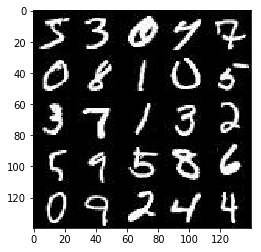

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

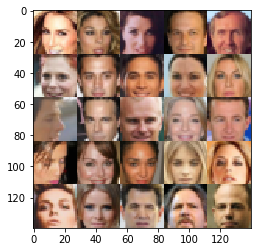

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    #print('images:', images.shape)
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print('relu1:', relu1.shape)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print('relu2:', relu2.shape)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print('relu3:', relu3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print('out:', out.shape)
        #print('logits:', logits.shape)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    reuse = not is_train
    training = is_train
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        #print('x1:', x1.shape)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        #print('x11:', x1.shape)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        #print('x2:', x2.shape)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        #print('x3:', x3.shape)
        # 16x16x128 now
        
        # Output layer
        #print(out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print('logits:', logits.shape)
        
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = 28
    image_height = 28
    
    image_channels = 1
    if data_image_mode == "RGB":
        image_channels = 3
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps = 0
    
    input_real, input_z, learningrate = model_inputs(image_width, image_height, image_channels, z_dim)
    #print('input_real:', input_real.shape)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            steps = 0
            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                        show_generator_output(sess, 2, input_z, image_channels, data_image_mode)

    return losses, samples
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Step 11... Discriminator Loss: 0.3280... Generator Loss: 1.5338
Epoch 1/2... Step 21... Discriminator Loss: 0.0819... Generator Loss: 3.1116
Epoch 1/2... Step 31... Discriminator Loss: 0.2699... Generator Loss: 1.7593
Epoch 1/2... Step 41... Discriminator Loss: 0.5768... Generator Loss: 1.8945
Epoch 1/2... Step 51... Discriminator Loss: 0.4801... Generator Loss: 2.2445
Epoch 1/2... Step 61... Discriminator Loss: 0.7943... Generator Loss: 2.1174
Epoch 1/2... Step 71... Discriminator Loss: 1.5843... Generator Loss: 2.7160
Epoch 1/2... Step 81... Discriminator Loss: 0.8905... Generator Loss: 2.1353
Epoch 1/2... Step 91... Discriminator Loss: 0.6825... Generator Loss: 1.6430
Epoch 1/2... Step 101... Discriminator Loss: 0.5747... Generator Loss: 1.6769


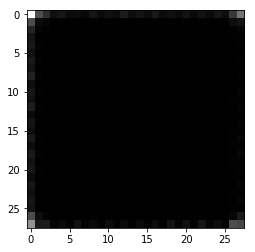

Epoch 1/2... Step 111... Discriminator Loss: 0.5889... Generator Loss: 1.3130
Epoch 1/2... Step 121... Discriminator Loss: 0.3580... Generator Loss: 2.3244
Epoch 1/2... Step 131... Discriminator Loss: 0.2734... Generator Loss: 1.8745
Epoch 1/2... Step 141... Discriminator Loss: 0.3484... Generator Loss: 1.8801
Epoch 1/2... Step 151... Discriminator Loss: 0.1510... Generator Loss: 2.6428
Epoch 1/2... Step 161... Discriminator Loss: 0.1536... Generator Loss: 2.4354
Epoch 1/2... Step 171... Discriminator Loss: 0.0777... Generator Loss: 3.1267
Epoch 1/2... Step 181... Discriminator Loss: 0.0457... Generator Loss: 4.1040
Epoch 1/2... Step 191... Discriminator Loss: 0.0718... Generator Loss: 3.1681
Epoch 1/2... Step 201... Discriminator Loss: 0.0534... Generator Loss: 3.5412


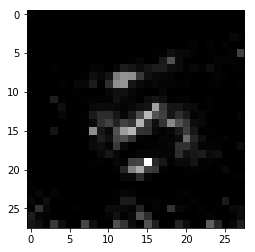

Epoch 1/2... Step 211... Discriminator Loss: 0.0255... Generator Loss: 4.7817
Epoch 1/2... Step 221... Discriminator Loss: 0.0662... Generator Loss: 3.4569
Epoch 1/2... Step 231... Discriminator Loss: 0.0660... Generator Loss: 3.6212
Epoch 1/2... Step 241... Discriminator Loss: 0.0315... Generator Loss: 3.9671
Epoch 1/2... Step 251... Discriminator Loss: 0.0122... Generator Loss: 4.8667
Epoch 1/2... Step 261... Discriminator Loss: 0.0060... Generator Loss: 6.3829
Epoch 1/2... Step 271... Discriminator Loss: 0.0039... Generator Loss: 8.5165
Epoch 1/2... Step 281... Discriminator Loss: 0.1382... Generator Loss: 2.2218
Epoch 1/2... Step 291... Discriminator Loss: 0.3737... Generator Loss: 5.0502
Epoch 1/2... Step 301... Discriminator Loss: 0.0193... Generator Loss: 7.2584


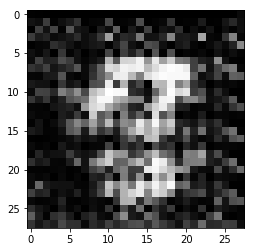

Epoch 1/2... Step 311... Discriminator Loss: 0.0619... Generator Loss: 3.4111
Epoch 1/2... Step 321... Discriminator Loss: 0.1043... Generator Loss: 2.6545
Epoch 1/2... Step 331... Discriminator Loss: 0.0525... Generator Loss: 10.6617
Epoch 1/2... Step 341... Discriminator Loss: 0.1571... Generator Loss: 2.7508
Epoch 1/2... Step 351... Discriminator Loss: 0.1132... Generator Loss: 3.1674
Epoch 1/2... Step 361... Discriminator Loss: 0.1688... Generator Loss: 3.3307
Epoch 1/2... Step 371... Discriminator Loss: 0.1597... Generator Loss: 2.3217
Epoch 1/2... Step 381... Discriminator Loss: 0.0078... Generator Loss: 9.7550
Epoch 1/2... Step 391... Discriminator Loss: 0.1294... Generator Loss: 2.7803
Epoch 1/2... Step 401... Discriminator Loss: 0.0271... Generator Loss: 4.2204


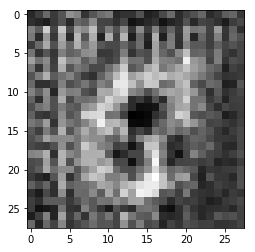

Epoch 1/2... Step 411... Discriminator Loss: 0.5778... Generator Loss: 1.4132
Epoch 1/2... Step 421... Discriminator Loss: 0.7473... Generator Loss: 10.4989
Epoch 1/2... Step 431... Discriminator Loss: 0.3864... Generator Loss: 1.6565
Epoch 1/2... Step 441... Discriminator Loss: 0.0392... Generator Loss: 6.2733
Epoch 1/2... Step 451... Discriminator Loss: 0.2464... Generator Loss: 2.3067
Epoch 1/2... Step 461... Discriminator Loss: 0.3143... Generator Loss: 2.6756
Epoch 2/2... Step 11... Discriminator Loss: 0.0862... Generator Loss: 5.1170
Epoch 2/2... Step 21... Discriminator Loss: 0.0758... Generator Loss: 4.9502
Epoch 2/2... Step 31... Discriminator Loss: 0.2601... Generator Loss: 2.3698
Epoch 2/2... Step 41... Discriminator Loss: 0.1238... Generator Loss: 3.8854
Epoch 2/2... Step 51... Discriminator Loss: 0.1815... Generator Loss: 6.5985
Epoch 2/2... Step 61... Discriminator Loss: 0.2109... Generator Loss: 2.8443
Epoch 2/2... Step 71... Discriminator Loss: 1.7337... Generator Loss:

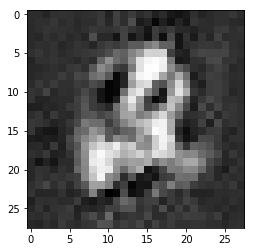

Epoch 2/2... Step 111... Discriminator Loss: 0.1529... Generator Loss: 3.3740
Epoch 2/2... Step 121... Discriminator Loss: 0.0468... Generator Loss: 5.3057
Epoch 2/2... Step 131... Discriminator Loss: 0.2378... Generator Loss: 4.0648
Epoch 2/2... Step 141... Discriminator Loss: 0.3927... Generator Loss: 1.6246
Epoch 2/2... Step 151... Discriminator Loss: 0.4917... Generator Loss: 1.3299
Epoch 2/2... Step 161... Discriminator Loss: 0.8860... Generator Loss: 8.1717
Epoch 2/2... Step 171... Discriminator Loss: 0.0414... Generator Loss: 4.9178
Epoch 2/2... Step 181... Discriminator Loss: 0.1098... Generator Loss: 3.4009
Epoch 2/2... Step 191... Discriminator Loss: 0.4298... Generator Loss: 8.2068
Epoch 2/2... Step 201... Discriminator Loss: 0.0418... Generator Loss: 4.7238


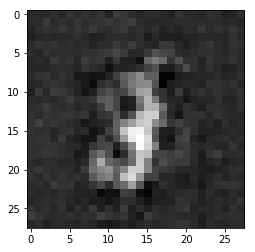

Epoch 2/2... Step 211... Discriminator Loss: 0.8437... Generator Loss: 6.1694
Epoch 2/2... Step 221... Discriminator Loss: 1.5327... Generator Loss: 0.4317
Epoch 2/2... Step 231... Discriminator Loss: 0.2378... Generator Loss: 2.6943
Epoch 2/2... Step 241... Discriminator Loss: 0.7662... Generator Loss: 0.9165
Epoch 2/2... Step 251... Discriminator Loss: 0.0225... Generator Loss: 6.5170
Epoch 2/2... Step 261... Discriminator Loss: 0.0533... Generator Loss: 8.2179
Epoch 2/2... Step 271... Discriminator Loss: 0.0855... Generator Loss: 11.8404
Epoch 2/2... Step 281... Discriminator Loss: 0.1871... Generator Loss: 2.2613
Epoch 2/2... Step 291... Discriminator Loss: 0.0761... Generator Loss: 3.2025
Epoch 2/2... Step 301... Discriminator Loss: 0.0442... Generator Loss: 8.2349


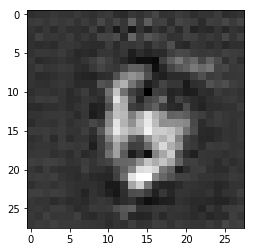

Epoch 2/2... Step 311... Discriminator Loss: 0.1340... Generator Loss: 5.4611
Epoch 2/2... Step 321... Discriminator Loss: 0.0428... Generator Loss: 6.9366
Epoch 2/2... Step 331... Discriminator Loss: 0.3759... Generator Loss: 1.4972
Epoch 2/2... Step 341... Discriminator Loss: 1.0789... Generator Loss: 6.0371
Epoch 2/2... Step 351... Discriminator Loss: 0.0722... Generator Loss: 7.3340
Epoch 2/2... Step 361... Discriminator Loss: 0.0450... Generator Loss: 9.1382
Epoch 2/2... Step 371... Discriminator Loss: 0.0599... Generator Loss: 3.8026
Epoch 2/2... Step 381... Discriminator Loss: 0.0418... Generator Loss: 4.1846
Epoch 2/2... Step 391... Discriminator Loss: 0.4874... Generator Loss: 5.4574
Epoch 2/2... Step 401... Discriminator Loss: 0.6562... Generator Loss: 1.0018


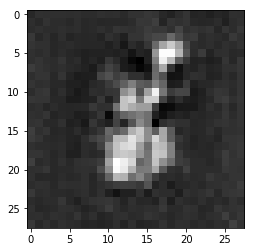

Epoch 2/2... Step 411... Discriminator Loss: 0.3929... Generator Loss: 1.3873
Epoch 2/2... Step 421... Discriminator Loss: 0.0353... Generator Loss: 5.3625
Epoch 2/2... Step 431... Discriminator Loss: 0.0990... Generator Loss: 7.1189
Epoch 2/2... Step 441... Discriminator Loss: 0.2241... Generator Loss: 1.8787
Epoch 2/2... Step 451... Discriminator Loss: 0.1046... Generator Loss: 4.2154
Epoch 2/2... Step 461... Discriminator Loss: 0.1104... Generator Loss: 2.9297


In [59]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Step 11... Discriminator Loss: 0.9884... Generator Loss: 0.7246
Epoch 1/1... Step 21... Discriminator Loss: 0.3714... Generator Loss: 1.9397
Epoch 1/1... Step 31... Discriminator Loss: 0.4265... Generator Loss: 1.6587
Epoch 1/1... Step 41... Discriminator Loss: 0.2616... Generator Loss: 2.1224
Epoch 1/1... Step 51... Discriminator Loss: 0.3888... Generator Loss: 1.4426
Epoch 1/1... Step 61... Discriminator Loss: 0.3076... Generator Loss: 1.5678
Epoch 1/1... Step 71... Discriminator Loss: 0.2238... Generator Loss: 2.6546
Epoch 1/1... Step 81... Discriminator Loss: 0.6688... Generator Loss: 1.3219
Epoch 1/1... Step 91... Discriminator Loss: 0.2438... Generator Loss: 2.7133
Epoch 1/1... Step 101... Discriminator Loss: 0.0870... Generator Loss: 3.4588


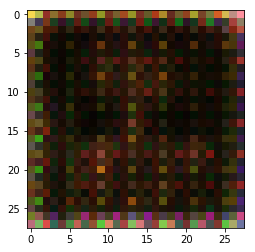

Epoch 1/1... Step 111... Discriminator Loss: 0.0988... Generator Loss: 3.5879
Epoch 1/1... Step 121... Discriminator Loss: 0.0793... Generator Loss: 3.0491
Epoch 1/1... Step 131... Discriminator Loss: 0.0165... Generator Loss: 6.9362
Epoch 1/1... Step 141... Discriminator Loss: 0.0227... Generator Loss: 5.6266
Epoch 1/1... Step 151... Discriminator Loss: 0.0114... Generator Loss: 7.1622
Epoch 1/1... Step 161... Discriminator Loss: 0.0337... Generator Loss: 3.9930
Epoch 1/1... Step 171... Discriminator Loss: 0.0278... Generator Loss: 7.7926
Epoch 1/1... Step 181... Discriminator Loss: 0.0152... Generator Loss: 6.7423
Epoch 1/1... Step 191... Discriminator Loss: 0.0260... Generator Loss: 4.4437
Epoch 1/1... Step 201... Discriminator Loss: 0.1241... Generator Loss: 3.8659


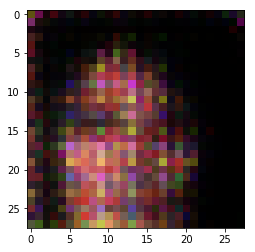

Epoch 1/1... Step 211... Discriminator Loss: 0.0607... Generator Loss: 4.3342
Epoch 1/1... Step 221... Discriminator Loss: 0.0121... Generator Loss: 5.9869
Epoch 1/1... Step 231... Discriminator Loss: 0.0494... Generator Loss: 3.5644
Epoch 1/1... Step 241... Discriminator Loss: 0.0021... Generator Loss: 7.3121
Epoch 1/1... Step 251... Discriminator Loss: 0.0048... Generator Loss: 8.2831
Epoch 1/1... Step 261... Discriminator Loss: 0.0054... Generator Loss: 7.0400
Epoch 1/1... Step 271... Discriminator Loss: 0.0229... Generator Loss: 10.8709
Epoch 1/1... Step 281... Discriminator Loss: 0.0046... Generator Loss: 11.9668
Epoch 1/1... Step 291... Discriminator Loss: 0.0061... Generator Loss: 7.1236
Epoch 1/1... Step 301... Discriminator Loss: 0.0165... Generator Loss: 4.5143


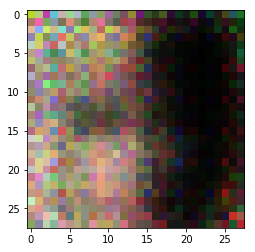

Epoch 1/1... Step 311... Discriminator Loss: 0.0029... Generator Loss: 9.9979
Epoch 1/1... Step 321... Discriminator Loss: 0.3041... Generator Loss: 4.2870
Epoch 1/1... Step 331... Discriminator Loss: 0.7861... Generator Loss: 0.8841
Epoch 1/1... Step 341... Discriminator Loss: 0.1209... Generator Loss: 4.3802
Epoch 1/1... Step 351... Discriminator Loss: 0.0295... Generator Loss: 5.9957
Epoch 1/1... Step 361... Discriminator Loss: 0.8827... Generator Loss: 3.9747
Epoch 1/1... Step 371... Discriminator Loss: 1.6487... Generator Loss: 0.9605
Epoch 1/1... Step 381... Discriminator Loss: 0.1272... Generator Loss: 5.1476
Epoch 1/1... Step 391... Discriminator Loss: 0.0973... Generator Loss: 4.6824
Epoch 1/1... Step 401... Discriminator Loss: 0.3843... Generator Loss: 1.5627


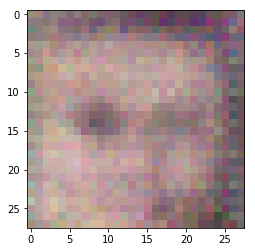

Epoch 1/1... Step 411... Discriminator Loss: 0.0596... Generator Loss: 4.3315
Epoch 1/1... Step 421... Discriminator Loss: 0.2249... Generator Loss: 2.5747
Epoch 1/1... Step 431... Discriminator Loss: 3.7329... Generator Loss: 6.5942
Epoch 1/1... Step 441... Discriminator Loss: 0.1781... Generator Loss: 2.6984
Epoch 1/1... Step 451... Discriminator Loss: 0.5264... Generator Loss: 3.8998
Epoch 1/1... Step 461... Discriminator Loss: 0.5000... Generator Loss: 7.6914
Epoch 1/1... Step 471... Discriminator Loss: 0.4818... Generator Loss: 6.5343
Epoch 1/1... Step 481... Discriminator Loss: 0.0754... Generator Loss: 3.4599
Epoch 1/1... Step 491... Discriminator Loss: 0.0493... Generator Loss: 4.6897
Epoch 1/1... Step 501... Discriminator Loss: 0.1348... Generator Loss: 3.4111


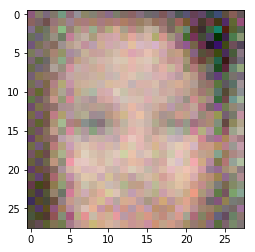

Epoch 1/1... Step 511... Discriminator Loss: 0.2062... Generator Loss: 2.6875
Epoch 1/1... Step 521... Discriminator Loss: 0.2288... Generator Loss: 2.3110
Epoch 1/1... Step 531... Discriminator Loss: 0.1201... Generator Loss: 2.8228
Epoch 1/1... Step 541... Discriminator Loss: 0.2400... Generator Loss: 1.9006
Epoch 1/1... Step 551... Discriminator Loss: 0.0146... Generator Loss: 7.5508
Epoch 1/1... Step 561... Discriminator Loss: 0.1148... Generator Loss: 2.9462
Epoch 1/1... Step 571... Discriminator Loss: 0.0296... Generator Loss: 9.9839
Epoch 1/1... Step 581... Discriminator Loss: 0.0375... Generator Loss: 5.5838
Epoch 1/1... Step 591... Discriminator Loss: 0.0723... Generator Loss: 3.2707
Epoch 1/1... Step 601... Discriminator Loss: 0.0633... Generator Loss: 7.5789


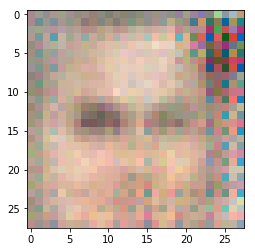

Epoch 1/1... Step 611... Discriminator Loss: 0.0554... Generator Loss: 5.8042
Epoch 1/1... Step 621... Discriminator Loss: 0.0924... Generator Loss: 3.4197
Epoch 1/1... Step 631... Discriminator Loss: 0.1340... Generator Loss: 2.4162
Epoch 1/1... Step 641... Discriminator Loss: 0.1788... Generator Loss: 2.2077
Epoch 1/1... Step 651... Discriminator Loss: 0.0504... Generator Loss: 3.9928
Epoch 1/1... Step 661... Discriminator Loss: 0.0143... Generator Loss: 9.0155
Epoch 1/1... Step 671... Discriminator Loss: 2.0840... Generator Loss: 5.1019
Epoch 1/1... Step 681... Discriminator Loss: 0.2153... Generator Loss: 9.5021
Epoch 1/1... Step 691... Discriminator Loss: 0.1353... Generator Loss: 3.0208
Epoch 1/1... Step 701... Discriminator Loss: 0.5599... Generator Loss: 1.1493


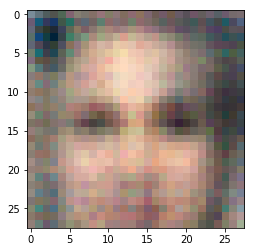

Epoch 1/1... Step 711... Discriminator Loss: 0.1353... Generator Loss: 4.1666
Epoch 1/1... Step 721... Discriminator Loss: 0.8918... Generator Loss: 5.5248
Epoch 1/1... Step 731... Discriminator Loss: 0.7806... Generator Loss: 3.2266
Epoch 1/1... Step 741... Discriminator Loss: 0.1309... Generator Loss: 5.3038
Epoch 1/1... Step 751... Discriminator Loss: 0.0787... Generator Loss: 6.4838
Epoch 1/1... Step 761... Discriminator Loss: 0.0360... Generator Loss: 4.8893
Epoch 1/1... Step 771... Discriminator Loss: 0.0897... Generator Loss: 4.5293
Epoch 1/1... Step 781... Discriminator Loss: 0.0897... Generator Loss: 4.0157
Epoch 1/1... Step 791... Discriminator Loss: 0.0231... Generator Loss: 6.2588
Epoch 1/1... Step 801... Discriminator Loss: 0.0793... Generator Loss: 8.4762


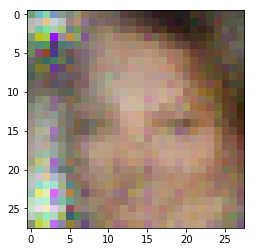

Epoch 1/1... Step 811... Discriminator Loss: 1.4147... Generator Loss: 8.9573
Epoch 1/1... Step 821... Discriminator Loss: 0.1371... Generator Loss: 3.0374
Epoch 1/1... Step 831... Discriminator Loss: 0.1365... Generator Loss: 10.4665
Epoch 1/1... Step 841... Discriminator Loss: 0.8335... Generator Loss: 0.9506
Epoch 1/1... Step 851... Discriminator Loss: 0.2186... Generator Loss: 2.4286
Epoch 1/1... Step 861... Discriminator Loss: 0.5705... Generator Loss: 1.2255
Epoch 1/1... Step 871... Discriminator Loss: 0.1191... Generator Loss: 8.6973
Epoch 1/1... Step 881... Discriminator Loss: 1.6576... Generator Loss: 5.7875
Epoch 1/1... Step 891... Discriminator Loss: 0.0323... Generator Loss: 5.6958
Epoch 1/1... Step 901... Discriminator Loss: 0.0647... Generator Loss: 4.1371


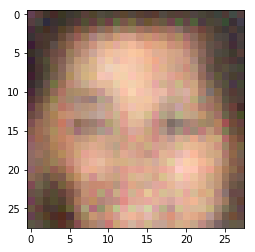

Epoch 1/1... Step 911... Discriminator Loss: 0.0459... Generator Loss: 8.1407
Epoch 1/1... Step 921... Discriminator Loss: 0.0224... Generator Loss: 8.0023
Epoch 1/1... Step 931... Discriminator Loss: 0.7548... Generator Loss: 5.2168
Epoch 1/1... Step 941... Discriminator Loss: 0.0480... Generator Loss: 5.5943
Epoch 1/1... Step 951... Discriminator Loss: 0.0182... Generator Loss: 11.3589
Epoch 1/1... Step 961... Discriminator Loss: 0.1331... Generator Loss: 3.0264
Epoch 1/1... Step 971... Discriminator Loss: 1.5231... Generator Loss: 0.6982
Epoch 1/1... Step 981... Discriminator Loss: 0.0513... Generator Loss: 12.8608
Epoch 1/1... Step 991... Discriminator Loss: 2.6899... Generator Loss: 0.1284
Epoch 1/1... Step 1001... Discriminator Loss: 0.5878... Generator Loss: 1.3834


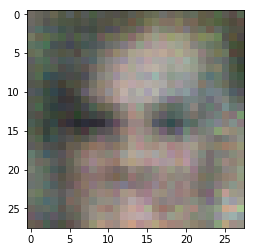

Epoch 1/1... Step 1011... Discriminator Loss: 0.1245... Generator Loss: 3.5802
Epoch 1/1... Step 1021... Discriminator Loss: 0.1634... Generator Loss: 6.2123
Epoch 1/1... Step 1031... Discriminator Loss: 0.1072... Generator Loss: 4.0785
Epoch 1/1... Step 1041... Discriminator Loss: 0.0601... Generator Loss: 4.7033
Epoch 1/1... Step 1051... Discriminator Loss: 0.1552... Generator Loss: 6.5881
Epoch 1/1... Step 1061... Discriminator Loss: 0.1655... Generator Loss: 3.2285
Epoch 1/1... Step 1071... Discriminator Loss: 0.0606... Generator Loss: 4.2324
Epoch 1/1... Step 1081... Discriminator Loss: 0.0845... Generator Loss: 5.3950
Epoch 1/1... Step 1091... Discriminator Loss: 0.0543... Generator Loss: 7.5576
Epoch 1/1... Step 1101... Discriminator Loss: 0.0556... Generator Loss: 6.5506


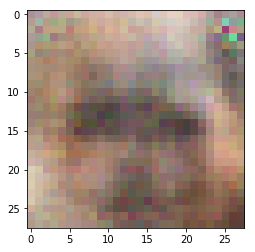

Epoch 1/1... Step 1111... Discriminator Loss: 0.4704... Generator Loss: 9.8782
Epoch 1/1... Step 1121... Discriminator Loss: 0.1267... Generator Loss: 3.1130
Epoch 1/1... Step 1131... Discriminator Loss: 0.3625... Generator Loss: 11.8361
Epoch 1/1... Step 1141... Discriminator Loss: 0.0100... Generator Loss: 7.1225
Epoch 1/1... Step 1151... Discriminator Loss: 0.0537... Generator Loss: 10.2562
Epoch 1/1... Step 1161... Discriminator Loss: 1.9901... Generator Loss: 1.4381
Epoch 1/1... Step 1171... Discriminator Loss: 1.2541... Generator Loss: 0.9252
Epoch 1/1... Step 1181... Discriminator Loss: 1.3185... Generator Loss: 0.5293
Epoch 1/1... Step 1191... Discriminator Loss: 1.3165... Generator Loss: 0.4980
Epoch 1/1... Step 1201... Discriminator Loss: 0.6335... Generator Loss: 1.4208


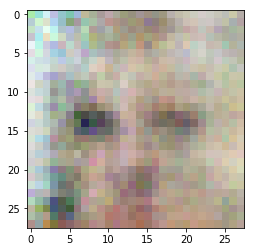

Epoch 1/1... Step 1211... Discriminator Loss: 0.2762... Generator Loss: 4.2565
Epoch 1/1... Step 1221... Discriminator Loss: 0.2650... Generator Loss: 1.9279
Epoch 1/1... Step 1231... Discriminator Loss: 0.0357... Generator Loss: 5.7490
Epoch 1/1... Step 1241... Discriminator Loss: 0.0893... Generator Loss: 7.7916
Epoch 1/1... Step 1251... Discriminator Loss: 0.4380... Generator Loss: 3.0318
Epoch 1/1... Step 1261... Discriminator Loss: 0.2770... Generator Loss: 3.4238
Epoch 1/1... Step 1271... Discriminator Loss: 0.0954... Generator Loss: 3.1261
Epoch 1/1... Step 1281... Discriminator Loss: 0.1588... Generator Loss: 5.5386
Epoch 1/1... Step 1291... Discriminator Loss: 1.3804... Generator Loss: 4.7889
Epoch 1/1... Step 1301... Discriminator Loss: 0.2089... Generator Loss: 4.2987


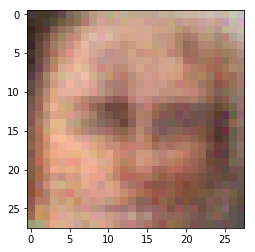

Epoch 1/1... Step 1311... Discriminator Loss: 0.2472... Generator Loss: 2.6007
Epoch 1/1... Step 1321... Discriminator Loss: 0.0829... Generator Loss: 3.4775
Epoch 1/1... Step 1331... Discriminator Loss: 0.2167... Generator Loss: 2.1421
Epoch 1/1... Step 1341... Discriminator Loss: 0.7495... Generator Loss: 5.0570
Epoch 1/1... Step 1351... Discriminator Loss: 0.0701... Generator Loss: 4.4689
Epoch 1/1... Step 1361... Discriminator Loss: 0.0370... Generator Loss: 10.3069
Epoch 1/1... Step 1371... Discriminator Loss: 0.0423... Generator Loss: 5.0497
Epoch 1/1... Step 1381... Discriminator Loss: 0.3599... Generator Loss: 10.4072
Epoch 1/1... Step 1391... Discriminator Loss: 0.3346... Generator Loss: 1.6823
Epoch 1/1... Step 1401... Discriminator Loss: 0.1666... Generator Loss: 5.4540


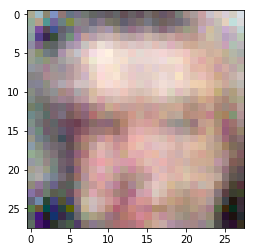

Epoch 1/1... Step 1411... Discriminator Loss: 0.0594... Generator Loss: 7.1372
Epoch 1/1... Step 1421... Discriminator Loss: 0.5149... Generator Loss: 1.3154
Epoch 1/1... Step 1431... Discriminator Loss: 0.1095... Generator Loss: 3.1088
Epoch 1/1... Step 1441... Discriminator Loss: 0.2495... Generator Loss: 2.3300
Epoch 1/1... Step 1451... Discriminator Loss: 0.1055... Generator Loss: 3.1438
Epoch 1/1... Step 1461... Discriminator Loss: 1.7822... Generator Loss: 0.8530
Epoch 1/1... Step 1471... Discriminator Loss: 0.0288... Generator Loss: 12.6833
Epoch 1/1... Step 1481... Discriminator Loss: 0.0534... Generator Loss: 3.9018
Epoch 1/1... Step 1491... Discriminator Loss: 0.2269... Generator Loss: 3.4228
Epoch 1/1... Step 1501... Discriminator Loss: 0.1036... Generator Loss: 3.0032


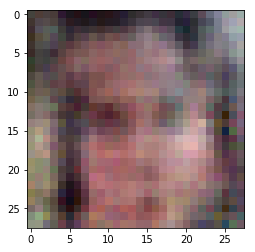

Epoch 1/1... Step 1511... Discriminator Loss: 0.1374... Generator Loss: 4.2422
Epoch 1/1... Step 1521... Discriminator Loss: 1.0350... Generator Loss: 0.8264
Epoch 1/1... Step 1531... Discriminator Loss: 0.7753... Generator Loss: 0.9432
Epoch 1/1... Step 1541... Discriminator Loss: 0.7935... Generator Loss: 0.8754
Epoch 1/1... Step 1551... Discriminator Loss: 0.0785... Generator Loss: 7.3728
Epoch 1/1... Step 1561... Discriminator Loss: 0.1743... Generator Loss: 2.5460
Epoch 1/1... Step 1571... Discriminator Loss: 0.6176... Generator Loss: 1.1470
Epoch 1/1... Step 1581... Discriminator Loss: 0.4093... Generator Loss: 1.5322


In [60]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。